In [1]:
import sys
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms, datasets
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import os
# import matplotlib.pyplot as plt
import numpy as np

py_file_location = "/home/chizm/PatchART/pgd"
sys.path.append(os.path.abspath(py_file_location))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.version.cuda)

Using cuda device
True
0
11.7


In [2]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet,self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.maxpool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(1024, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self,x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        x = self.relu(x)
        # x = torch.flatten(x, 1)
        x = x.view(-1,1024)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # x = torch.sigmoid(x)
        return x
    
    # split the model into two parts, first part is the feature extractor until fc1, second part is the classifier
    def split(self):
        return nn.Sequential(
            self.conv1,
            self.maxpool,
            self.relu,
            self.conv2,
            self.maxpool,
            self.relu,
            # torch.flatten(x, 1),
            nn.Flatten(),
            self.fc1,
            self.relu
        ), nn.Sequential(
            
            self.fc2
            # nn.Sigmoid()
        )
    
    # use the self.split() to get the feature extractor until fc1
    def get_the_feature(self,x):
        x = self.split()[0](x)
        return x

In [3]:
model = NeuralNet().to(device)
model.load_state_dict(torch.load("/home/chizm/PatchART/pgd/model/pdg_net.pth"))
model.eval()

NeuralNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [4]:
dataset = torch.load("/home/chizm/PatchART/data/MNIST/processed/test_attack_data_part.pt")

In [5]:
atk_images, labels = dataset

In [6]:
adv_op = model(atk_images)


In [7]:
_,p_adv = torch.max(adv_op, dim = 1)

In [8]:
p_adv

tensor([8, 4, 5, 9, 9, 9, 2, 2, 5, 9, 5, 7, 7, 5, 2, 9, 0, 8, 3, 0, 4, 9, 9, 5,
        4, 9, 8, 9, 5, 5, 8, 8, 2, 9, 4, 9, 9, 4, 4, 3, 8, 9, 9, 3, 8, 2, 9, 8,
        3, 8, 9, 3, 4, 4, 8, 4, 8, 8, 3, 4, 3, 5, 9, 2, 2, 3, 9, 5, 3, 2, 5, 2,
        2, 2, 9, 2, 0, 4, 0, 5, 3, 3, 2, 5, 5, 3, 2, 2, 8, 3, 5, 5, 3, 8, 7, 9,
        1, 3, 4, 9, 2, 5, 3, 5, 5, 9, 4, 4, 9, 4, 0, 5, 3, 9, 2, 5, 4, 2, 7, 3,
        5, 7, 9, 8, 8, 3, 9, 9, 4, 9, 9, 4, 2, 5, 9, 9, 5, 5, 8, 0, 5, 9, 8, 5,
        5, 1, 5, 9, 5, 9, 3, 3, 3, 7, 9, 5, 7, 4, 9, 8, 0, 8, 8, 5, 5, 3, 8, 3,
        4, 2, 2, 4, 9, 3, 3, 8, 9, 8, 5, 5, 2, 3, 4, 8, 9, 3, 8, 2, 7, 2, 8, 5,
        5, 9, 6, 8, 9, 8, 8, 4, 4, 9, 4, 3, 3, 4, 9, 5, 4, 7, 9, 2, 3, 2, 2, 3,
        5, 4, 4, 9, 2, 3, 9, 9, 9, 7, 9, 8, 4, 9, 3, 5, 9, 9, 3, 9, 5, 9, 9, 8,
        3, 9, 2, 9, 2, 5, 9, 9, 3, 5, 3, 9, 3, 3, 2, 8, 5, 9, 8, 3, 8, 3, 4, 8,
        3, 9, 2, 5, 9, 9, 3, 8, 5, 4, 3, 6, 3, 2, 9, 7, 5, 5, 5, 2, 3, 3, 9, 5,
        9, 3, 7, 8, 8, 9, 5, 5, 0, 5, 5,

In [9]:
num_equal = (p_adv == labels).sum().item()

In [10]:
num_equal

0

In [11]:
feature_atk_labels = model.get_the_feature(atk_images)

In [12]:
_,fp_adv = torch.max(feature_atk_labels, dim = 1)

In [13]:
feature_num_equal = (fp_adv == labels).sum().item()
feature_num_equal

4

In [1]:
import torch

a = torch.tensor([1,2,3])
b = torch.tensor([1,2,3])
a*b

tensor([1, 4, 9])

In [3]:
import torch

a = torch.tensor([[1,2,3],[1,4,5]])
b = torch.tensor([[1,2,3],[1,4,5]])
a*b

tensor([[ 1,  4,  9],
        [ 1, 16, 25]])

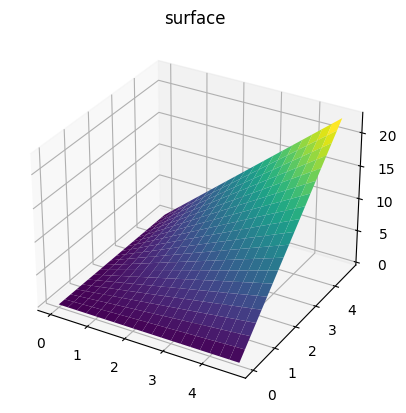

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# draw z = xy 3D graph from x = -5 to 5, y = -5 to 5
x = np.arange(0, 5, 0.25)
y = np.arange(0, 5, 0.25)
X, Y = np.meshgrid(x, y)
Z = X*Y

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title('surface')
plt.show()

In [12]:
import torch

A = torch.tensor([[[1,2,3],[1,4,5]],[[1,2,3],[1,4,5]]])
A.shape

torch.Size([2, 2, 3])

In [14]:
C = torch.sum(A, dim = 2)
C

tensor([[ 6, 10],
        [ 6, 10]])

In [16]:
D = C.unsqueeze(-1)
D

tensor([[[ 6],
         [10]],

        [[ 6],
         [10]]])

In [11]:

C.unsqueeze(2).expand_as(A)

tensor([[[ 6,  6,  6],
         [10, 10, 10]],

        [[ 6,  6,  6],
         [10, 10, 10]]])

In [2]:
import torch
trainset = torch.load('/home/chizm/PatchART/data/MNIST/processed/test.pt')
inputs,labels = trainset

In [4]:
inputs.shape

torch.Size([60000, 28, 28])

In [8]:
inputs[1]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [5]:
labels.shape

torch.Size([60000])

In [39]:
trainattackset = torch.load('/home/chizm/PatchART/data/MNIST/processed/train_attack_data_part.pt')
atk_inputs,atk_labels = trainattackset

In [41]:
atk_inputs.shape


torch.Size([1000, 1, 28, 28])

In [42]:
atk_labels.shape

torch.Size([1000])

In [43]:
testattackset = torch.load('/home/chizm/PatchART/data/MNIST/processed/test_attack_data_part.pt')
tatk_inputs,tatk_labels = testattackset

In [44]:
tatk_inputs.shape

torch.Size([500, 1, 28, 28])

In [45]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
train = datasets.MNIST('./data/', train=True,
                       transform=transforms.Compose([transforms.ToTensor()]),
                       download=True)
train_loader = DataLoader(train, batch_size=128)

In [46]:
train.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [25]:
train[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [47]:
traindata_list = []
trainlabel_list = []
for x,y in train_loader:
    traindata_list.append(x)
    trainlabel_list.append(y)

train_data = torch.cat(traindata_list)
train_label = torch.cat(trainlabel_list)


In [50]:
train_data.shape

torch.Size([60000, 1, 28, 28])

In [51]:
train_label.shape

torch.Size([60000])

In [52]:
train_data = train_data
torch.save((train_data,train_label),"/home/chizm/PatchART/data/MNIST/processed/train_norm00.pt")

In [53]:

test = datasets.MNIST('./data/', train=False,
                       transform=transforms.Compose([transforms.ToTensor()]),
                       download=True)
test_loader = DataLoader(test, batch_size=128)
testdata_list = []
testlabel_list = []
for x,y in test_loader:
    testdata_list.append(x)
    testlabel_list.append(y)

test_data = torch.cat(testdata_list)
test_label = torch.cat(testlabel_list)
test_data = test_data
test_data.shape


torch.Size([10000, 1, 28, 28])

In [54]:
test_label.shape

torch.Size([10000])

In [55]:
torch.save((test_data,test_label),"/home/chizm/PatchART/data/MNIST/processed/test_norm00.pt")